In [1]:
# Import PyTorch Data Loader Library
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision.models.segmentation import fcn_resnet50

# Other Library Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Custom Imports
from DRAC_Dataloading import DRAC_Loader
from DRAC_Models import ResNetBinary
from DRAC_Training import train_model
from DRAC_Testing import test_model
from DRAC_Criterion import DiceLoss

# Warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
torch.__version__

'2.0.1'

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(0))

cuda:0
NVIDIA RTX A5000


In [4]:
## Default Variables ##
# Datasets #


# Dataloader #
batch_size = 2

# Model #
model = fcn_resnet50(num_classes=2)
model_name = 'fcn_resnet50'
#criterion =  DiceLoss(smooth=1e-4)
#criterion_name = 'DiceLoss'
criterion = nn.CrossEntropyLoss()
criterion_name = 'CrossEntropyLoss'
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 100

In [5]:
# Key Data Locations
# Select 'train' or 'test' data.
train_data_intra = DRAC_Loader(data_type = 'train', transform = None, mask = "intraretinal")
test_data_intra = DRAC_Loader(data_type = 'test', transform = None, mask = "intraretinal")

train_data_neo = DRAC_Loader(data_type = 'train', transform = None, mask = "neovascular")
test_data_neo = DRAC_Loader(data_type = 'test', transform = None, mask = "neovascular")

train_data_nonper = DRAC_Loader(data_type = 'train', transform = None, mask = "nonperfusion")
test_data_nonper = DRAC_Loader(data_type = 'test', transform = None, mask = "nonperfusion")

In [6]:
# Load every item into a DataLoader
train_loader_intra = DataLoader(train_data_intra, batch_size=batch_size, shuffle=True)
test_loader_intra = DataLoader(test_data_intra, batch_size=batch_size, shuffle=True)

train_loader_neo = DataLoader(train_data_neo, batch_size=batch_size, shuffle=True)
test_loader_neo = DataLoader(test_data_neo, batch_size=batch_size, shuffle=True)

train_loader_nonper = DataLoader(train_data_nonper, batch_size=batch_size, shuffle=True)
test_loader_nonper = DataLoader(test_data_nonper, batch_size=batch_size, shuffle=True)

In [9]:
loaders = [train_loader_intra, train_loader_neo, train_loader_nonper]
loader_names = ['Intraretinal', 'Neovascularization', 'Nonperfusion']

folder = f'models/{model_name}_{batch_size}_{epochs}_{criterion_name}'

# Check to see if the folder exists, if not, create it. If it does, cycle through number interations until a new folder is created.
if not os.path.exists(folder):
    os.makedirs(folder)
else:
    i = 1
    while os.path.exists(f'{folder}_{i}'):
        i += 1
    folder = f'{folder}_{i}'
    os.makedirs(folder)

all_losses = []
count = 0
for train_loader in loaders:
    model, loss = train_model(model, train_loader, criterion, optimizer, epochs=epochs, criterion_name=criterion_name, segmentation_name=loader_names[count])
    count += 1

    
    path_location = f'{folder}/{loader_names[loaders.index(train_loader)]}.pth'
    
    # Save the model
    torch.save(model.state_dict(), path_location)
    all_losses.append(loss)

[Epoch 1/2] Intraretinal - Loss: 0.0683 | Time Spent: 15.38s
[Epoch 2/2] Intraretinal - Loss: 0.0317 | Time Spent: 15.54s
Training completed in 30.92s
[Epoch 1/2] Neovascularization - Loss: 0.0274 | Time Spent: 15.65s
[Epoch 2/2] Neovascularization - Loss: 0.0220 | Time Spent: 15.71s
Training completed in 31.36s


KeyboardInterrupt: 

In [ ]:
saveModel = True
name = f'models/{model_name}_{batch_size}_{epochs}_{criterion_name}'

# Checks to see if name exists, if not cycles through and adds _i to the end of the name, with i being the number of times it has cycled through
if os.path.exists(name):
    i = 1
    while os.path.exists(name):
        name = f'models/{model_name}_{batch_size}_{epochs}_{criterion_name}_{i}'
        i += 1

# Ensure that the models folder exists
if not os.path.exists('models'):
    os.makedirs('models')

# Save the model to models folder
if saveModel: torch.save(model.state_dict(), f'{name}.pth')

In [ ]:
# Checks to see if graphs folder exists #
if not os.path.exists('graphs'):
    os.makedirs('graphs')

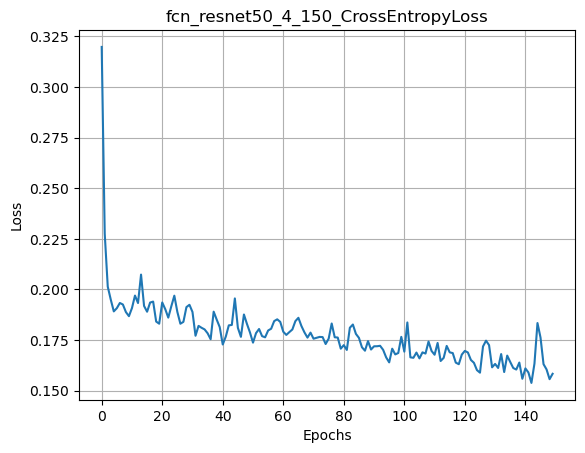

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot the loss
plot = True
for loss in all_losses:
    plt.plot(loss)
    plt.title(name)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid()
    plt.show()